# Initializing

In [19]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Pipeline
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    make_scorer
)

# Base + Models
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV

# Imbalanced learning
from imblearn.pipeline import Pipeline
from imblearn.base import BaseSampler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# Utils
from collections import Counter
from typing import Optional, Union, Literal, Iterable


# FraudDetector Class
A new method ```experiment_fit``` was made for demonstration and experimentation within this notebook. It allows us to easily switch between different class imbalance handling strategies (e.g., SMOTE, RandomUnderSampler, TomekLinks) and apply optional sample weights when fitting the model.

In [20]:
class FraudDetector(BaseEstimator, ClassifierMixin):

    def __init__(self, random_state: int = 39, n_jobs: Optional[int] = None):
        self.random_state = random_state
        self.n_jobs = n_jobs
        self._model_ = RandomForestClassifier(
            n_estimators=500,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )

    def fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        sample_weight: Optional[Iterable[float]] = None,
    ):
        """
        Fit the model using a training X and y.

        Parameters:
        -----------
        X (np.ndarray | pd.DataFrame): The training data
        y (np.ndarray | pd.Sereis): The corresponding targets
        sample_weight (iterable): Sample class weights (default=None)
        """

        X_balanced, y_balanced = self._handle_imbalance(X, y) # you can modify the parameters here if needed
        if sample_weight is None:
            self._model_.fit(X_balanced, y_balanced)
        else:
            self._model_.fit(X_balanced, y_balanced, sample_weight=sample_weight)
        return self

    def experiment_fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        sample_strategy: Optional[BaseSampler] = None,
        sample_weight: Optional[Iterable[float]] = None,
    ) -> dict[str, np.ndarray]:
        """
        Fit an imbalanced-learn pipeline on the training data.

        This method is designed for experimentation. It allows you to
        easily switch between different class imbalance handling
        strategies (e.g., SMOTE, RandomUnderSampler) and apply optional
        sample weights when fitting the model.

        Parameters
        ----------
        X : np.ndarray | pd.DataFrame
            Training data.
        y : np.ndarray | pd.Series
            Target labels.
        sample_strategy : BaseSampler, optional
            Resampling strategy (default=None).
        sample_weight : iterable, optional
            Sample weights for fitting (default=None).

        Returns
        -------
        dict
            Contains the key:value pair of str to the mean validation scores
        """
        # Build pipeline
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=36)
    
        # Build pipeline
        steps = []
        if sample_strategy is not None:
            steps.append(("sampler", sample_strategy))  # e.g., SMOTE(), RandomUnderSampler()
        steps.append(("clf", self._model_))

        pipeline = Pipeline(steps=steps)

        # Define the scorers
        fcr_scorer = make_scorer(recall_score, pos_label=1)

        # Detection: macro recall
        detection_scorer = make_scorer(recall_score, average="macro")

        scorers = {
            "precision": make_scorer(precision_score, average="macro", zero_division=0),
            "recall": make_scorer(recall_score, average="macro", zero_division=0),
            "f1": make_scorer(f1_score, average="macro", zero_division=0),
            "fcr": fcr_scorer,
            "detection": detection_scorer,
            "abs_net_value": FraudDetector.abs_net_value_scorer,
            "rel_net_value": FraudDetector.rel_net_value_scorer,
        }

        # GridSearchCV
        if sample_weight is not None:
            param_grid = {
                "clf__n_estimators": [500],
                "clf__class_weight": ['balanced']
            }
        else:
            param_grid = {
                "clf__n_estimators": [500],
            }
            
        search = GridSearchCV(
            estimator=pipeline,
            scoring=scorers,
            param_grid=param_grid,
            refit="fcr",       
            cv=skf,
            n_jobs=-1,
            verbose=1
        )

        search.fit(X, y)

        return search.cv_results_ 


    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """Predict the outcome from data X."""
        check_is_fitted(self, "_model_")
        return self._model_.predict(X)

    def fit_predict(
        self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]
    ) -> np.ndarray:
        """
        Fit the model using a training X and y, and predict the outcome using
        X. Note that this would give the predicted labels during training.
        """
        return self.fit(X, y).predict(X)

    def _handle_imbalance(self, X, y):
        return X, y

    #### END MODIFY THIS METHOD

    # Helper functions
    @staticmethod
    def abs_net_value_scorer(estimator, X, y):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y_pred = estimator.predict(X)
        amount = X.iloc[:, -1]  # last column as transaction value
        caught_value = amount[(y == 1) & (y_pred == 1)].sum()
        return caught_value
    
    @staticmethod
    def rel_net_value_scorer(estimator, X, y):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y_pred = estimator.predict(X)
        amount = X.iloc[:, -1]  # last column as transaction value
        caught_value = amount[(y == 1) & (y_pred == 1)].sum()
        total_fraud = amount[(y == 1)].sum()
        return caught_value/ total_fraud if total_fraud != 0 else 0

# EDA

Our overall objectives are:
1. To understand why the older methods of thresholding and flagging unusual transaction amounts are no longer effective.
2. To improve the prediction of fraudulent transactions.

For the first objective, we will examine patterns that differentiate fraudulent transactions from non-fraudulent ones by doing an EDA.
For the second objective, we will evaluate different sampling strategies and class weighting while keeping the Random Forest classifier with 500 estimators as a controlled variable. This is because Mara has already established that baseline, and our goal is to build on top of her work.


In [21]:
df = pd.read_csv('historical.csv')

# Drop tid because it is just a unique id
df = df.drop(columns = ['tid'])

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,0.635636,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,-1.470780,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,-0.947894,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,0.080683,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,-1.054033,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


## Data Preprocessing

No missing data were found, but duplicate entries were identified and removed. A total of 4,670 duplicates were dropped, leaving 97.4% of the data for analysis.

In [22]:
print(f'Number of missing data points is {df.isnull().sum().sum()}.')
print(f'Number of duplicated data points is {df.duplicated().sum()}.')

# Deduplicate the dataframe
df = df.drop_duplicates()

Number of missing data points is 0.
Number of duplicated data points is 4670.


## 1. To understand why the older methods of thresholding and flagging unusual transaction amounts are no longer effective

First, there is relatively little data available on fraudulent transactions, with at most 305 cases recorded in the ```historical.csv``` dataset while having 180,149 non-fraudulent cases. As shown in Figure 1, this results in a pronounced class imbalance between fraudulent and non-fraudulent transactions.

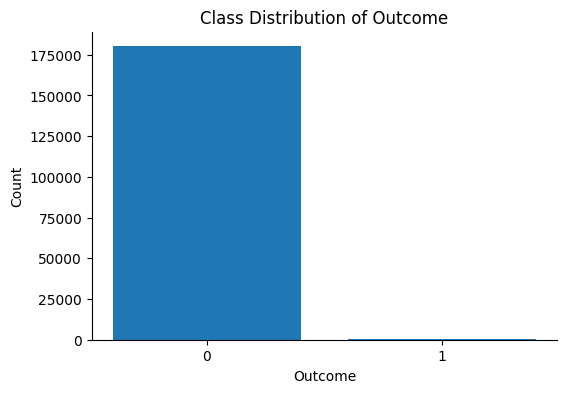

In [23]:
# Count values
class_counts = df["outcome"].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution of Outcome")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


Second, the traditional methods of thresholding and flagging unusual transaction amounts are no longer effective because fraudsters have adapted to these rules. As shown in the box plot in Figure 2, the median transaction amount for fraud cases is actually lower than that of non-fraud cases. Furthermore, even the outliers among fraudulent transactions are not as extreme when compared to non-fraudulent ones. While non-fraud transactions can reach values on the order of $10^4$, the highest fraudulent transactions only reach around $10^3$.

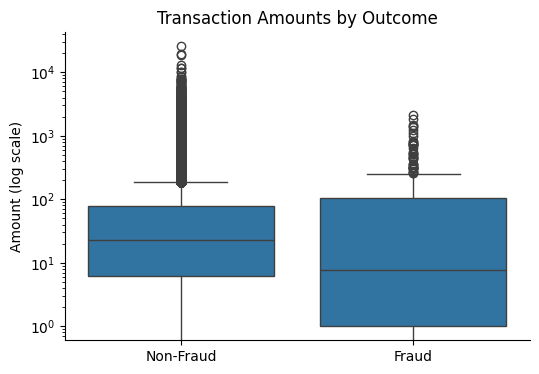

In [24]:
plt.figure(figsize=(6,4))

sns.boxplot(
    x="outcome",
    y="Amount",
    data=df
)
plt.yscale("log")  # handle skewness
plt.title("Transaction Amounts by Outcome")
plt.xlabel("")
plt.ylabel("Amount (log scale)")
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


In contrast to using only transaction amounts, we can also look at the principal components. Figure 3 shows little to no correlation among non-fraudulent transactions while fraudulent transactions display stronger relationships in the heatmap. This suggests that fraud data contains patterns that machine learning can exploit to improve prediction.

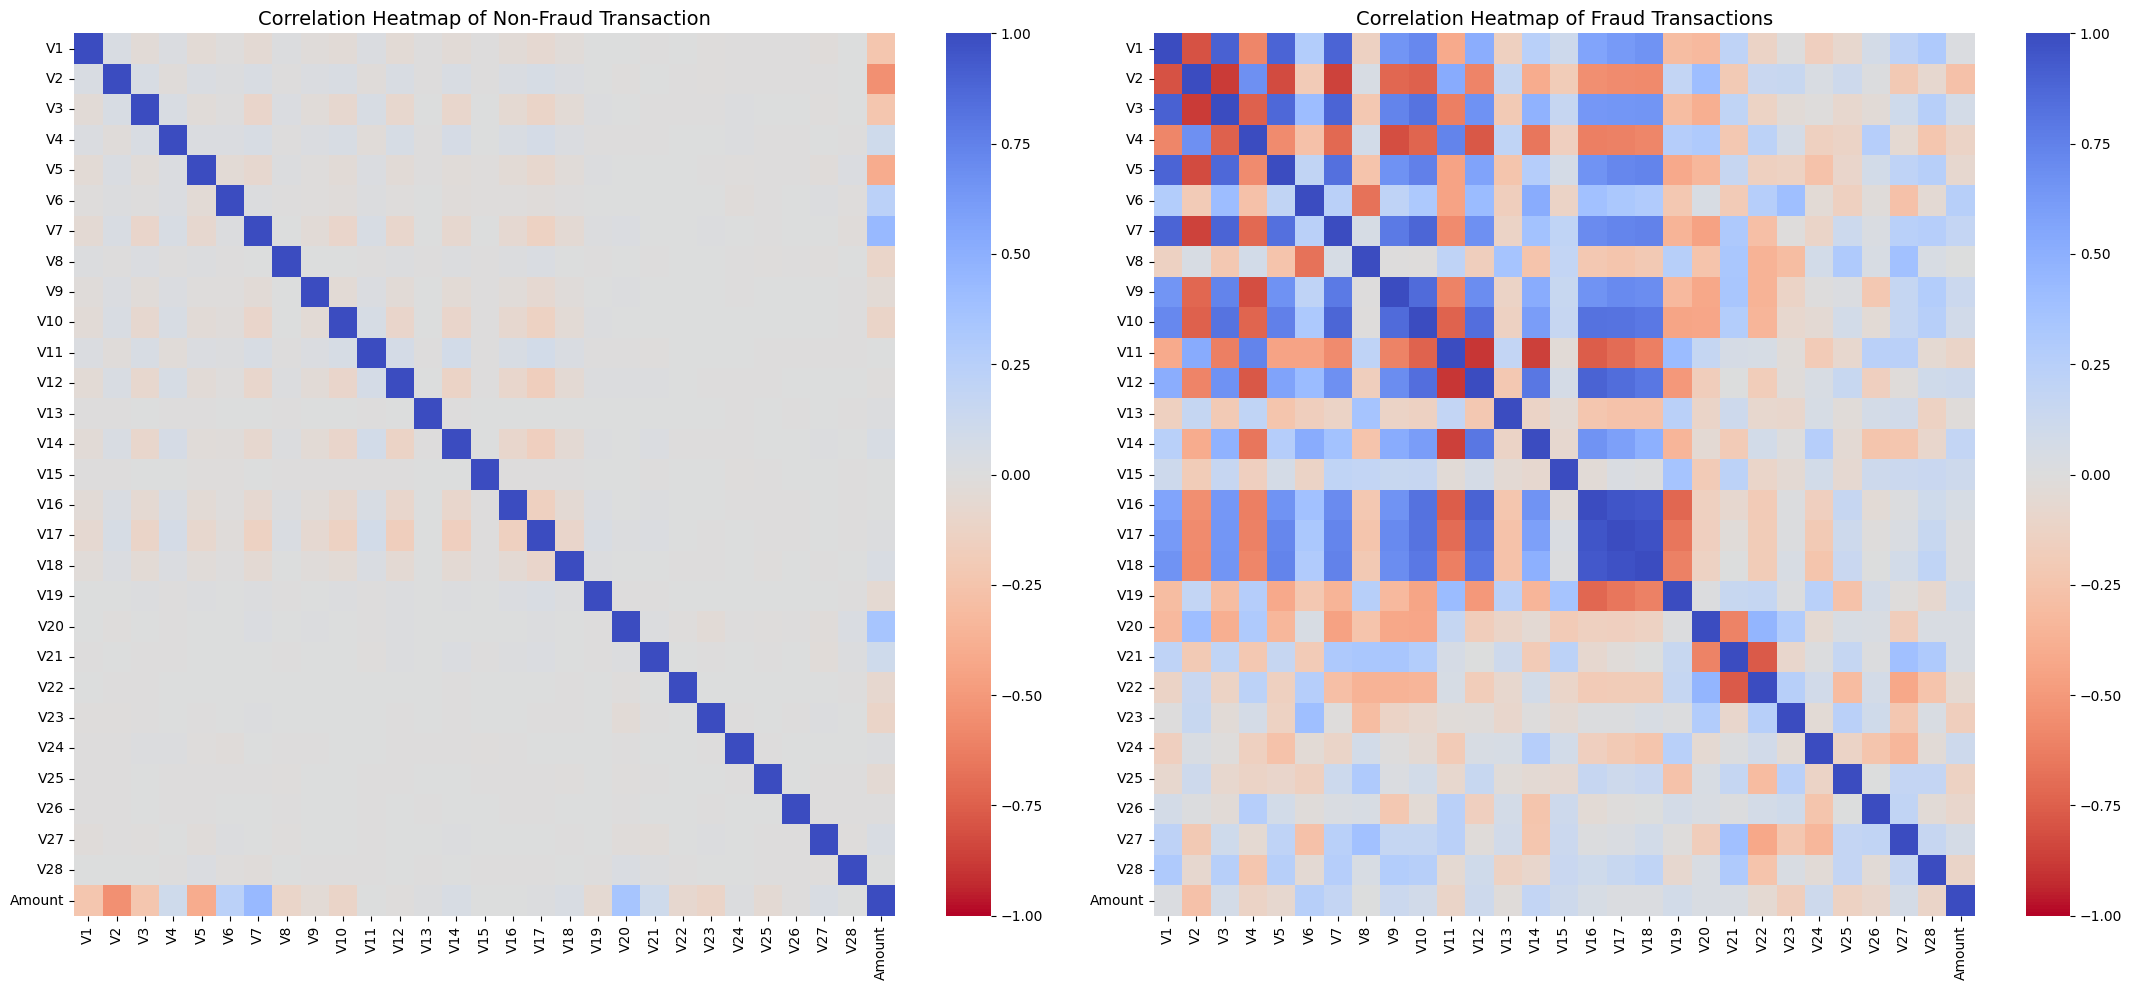

In [25]:
# Split datasets
is_fraud = df["outcome"] == 1
df_0 = df[~is_fraud]
df_1 = df[is_fraud]

# Compute correlation matrices
corr_0 = df_0.iloc[:, :-1].corr()
corr_1 = df_1.iloc[:, :-1].corr()

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(
    corr_0,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Correlation Heatmap of Non-Fraud Transaction", fontsize=14)

sns.heatmap(
    corr_1,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Correlation Heatmap of Fraud Transactions", fontsize=14)

plt.tight_layout()
plt.show()

To further visualize the patterns in fraud data, two scatterplots were made in Figure 4 to show the relationships of V1 to V3 (a) and V18 to V16 (b). These plots further emphasizes how fraud transactions (red) cluster differently from non-fraud ones (blue), suggesting that certain components capture meaningful distinctions between the two classes.

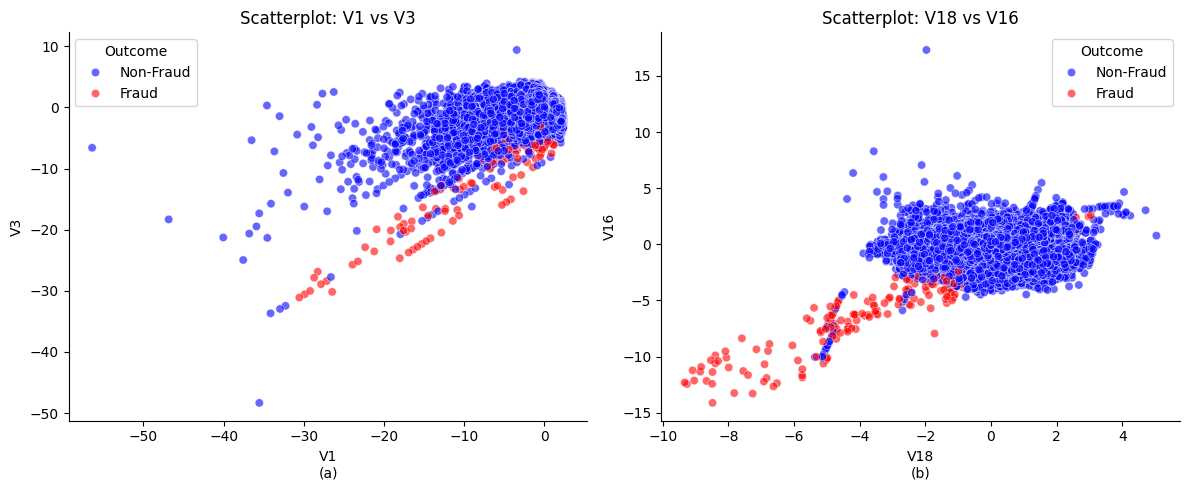

In [26]:
plt.figure(figsize=(12, 5))

# V1 vs V3
plt.subplot(1, 2, 1)
ax1 = sns.scatterplot(
    data=df,
    x="V1", y="V3",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
legend1 = ax1.legend_
legend1.set_title("Outcome")
for t, new_label in zip(legend1.texts, ["Non-Fraud", "Fraud"]):
    t.set_text(new_label)
plt.title("Scatterplot: V1 vs V3")
ax1.set_xlabel('V1\n(a)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


# V18 vs V16
plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(
    data=df,
    x="V18", y="V16",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
legend2 = ax2.legend_
legend2.set_title("Outcome")
for t, new_label in zip(legend2.texts, ["Non-Fraud", "Fraud"]):
    t.set_text(new_label)
plt.title("Scatterplot: V18 vs V16")
ax2.set_xlabel('V18\n(b)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


# 2. To improve the prediction of fraudulent transactions.

Let us now define the metrics that we shall use to optimize the model. We have:
1. Detection Rate
    * This asks, "Out of all transactions, how well does the model is at correctly identifying both fraud and non-fraud overall, where both are equally important?"

2. Fraud Capture Rate
    * This asks, "Out of all the fraud cases, how many did the model actually catch?"

3. Net Value Gained  - 
    * This asks, "How much money does the model helps save (by catching fraud)?"

Because we can only use one metric to optimize the model, we choose the Fraud Capture Rate to optimize since our second objective is to improve the prediction of fraudulent transactions. This metric aligns closely with CreditByte’s business-critical goal of reducing credit card fraud. For additional business context, we also report Net Value Gained to reflect the monetary impact. The technical definitions of all metrics used are provided below.

1. **Detection Rate which is the same as Macro Recall**  
Detection Rate:  

$$
\text{Detection Rate} = \frac{1}{2} \bigg(\frac{TP_{\text{fraud}}}{TP_{\text{fraud}} + FN_{\text{fraud}}} + \frac{TP_{\text{nonfraud}}}{TP_{\text{nonfraud}} + FN_{\text{nonfraud}}} \bigg)
$$

where  
- $n_{\text{fraud}}$ = number of fraud samples  
- $n_{\text{nonfraud}}$ = number of non-fraud samples  
- $N$ = total number of samples  
- $TP_{\text{fraud}}$ = fraud cases correctly identified  
- $FN_{\text{fraud}}$ = fraud cases missed  
- $TP_{\text{nonfraud}}$ = non-fraud cases correctly identified  
- $FN_{\text{nonfraud}}$ = non-fraud cases missed  


2. **Fraud Capture Rate, which is the same as Recall for Fraud Transactions**  

$$
\text{Fraud Capture Rate} = \frac{TP_{\text{fraud}}}{TP_{\text{fraud}} + FN_{\text{fraud}}}
$$  

where  
- $TP_{\text{fraud}}$ = fraud cases correctly identified  
- $FN_{\text{fraud}}$ = fraud cases missed  


3. **Net Value**  

$$
\text{Net Value} = V_{\text{caught}}
$$  

where  
- $V_{\text{caught}}$ = total value of fraud correctly detected 




## Handle Class Imbalance

In [27]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Create the training and test (hold-out) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X shape: {X.shape}")

X_train shape: (144363, 29)
X_test shape: (36091, 29)
X shape: (180454, 29)


In [28]:
def see_metrics(result):
    # List of metrics
    metrics = ['precision', 
               'recall', 
               'f1', 
               'fcr', 
               'detection', 
               'abs_net_value', 
               'rel_net_value']
    
    formal_metrics = ['(Macro) Precision', 
                      '(Macro) Recall', 
                      '(Macro) F1-Score', 
                      'Fraud Capture Rate', 
                      'Detection Rate', 
                      'Absolute Net Value', 
                      'Relative Net Value']

    # Build summary DataFrame
    summary_df = pd.DataFrame({
        "Mean": [result[f"mean_test_{m}"][0] for m in metrics],
        "Standard Deviation": [result[f"std_test_{m}"][0] for m in metrics]
    }, index=formal_metrics)
    return summary_df.round(2)


In [29]:
# Set a baseline model with no resampling strategies done
baseline_model = FraudDetector()
baseline_results = baseline_model.experiment_fit(X_train, y_train)
see_metrics(baseline_results)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

# Handle Class Imbalance

We will begin by examining five primary approaches to handling class imbalance: random undersampling, random oversampling, SMOTE, ADASYN, and Tomek Links. Afterward, we will also test the use of class weights. Finally, we will select the most effective method among the five and explore a hybrid approach that combines a resampling strategy with class weighting.

### a. Five Primary Approaches

In [ ]:
# Check for each possible way to handle class imbalances
random_seed = 92
rus = RandomUnderSampler(random_state=random_seed)
rus_model = FraudDetector().experiment_fit(X_train, y_train, sample_strategy=rus)
see_metrics(rus_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.53,0.00
(Macro) Recall,0.93,0.01
(Macro) F1-Score,0.54,0.01
Fraud Capture Rate,0.89,0.02
Detection Rate,0.93,0.01
Absolute Net Value,4532.35,1066.38
Relative Net Value,0.82,0.20


In [ ]:
# For Oversampling
ros = RandomOverSampler(random_state=random_seed)
ros_model = FraudDetector().experiment_fit(X_train, y_train, sample_strategy=ros)
see_metrics(ros_model)

In [ ]:
# For SMOTE
smote = SMOTE(random_state=random_seed)
smote_model = FraudDetector().experiment_fit(X_train, y_train, sample_strategy=smote)
see_metrics(smote_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.94,0.02
(Macro) Recall,0.91,0.04
(Macro) F1-Score,0.92,0.02
Fraud Capture Rate,0.81,0.07
Detection Rate,0.91,0.04
Absolute Net Value,4039.28,819.13
Relative Net Value,0.74,0.19


In [ ]:
# For ADASYN
adasyn = ADASYN(random_state=random_seed, n_neighbors=5, sampling_strategy="minority")
adasyn_model = FraudDetector().experiment_fit(X_train, y_train, sample_strategy=adasyn)
see_metrics(adasyn_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.93,0.02
(Macro) Recall,0.90,0.04
(Macro) F1-Score,0.91,0.02
Fraud Capture Rate,0.80,0.08
Detection Rate,0.90,0.04
Absolute Net Value,4039.23,819.00
Relative Net Value,0.74,0.19


In [ ]:
# For TOMEK'LINKS
tomek = TomekLinks(sampling_strategy="auto")
tomek_model = FraudDetector().experiment_fit(X_train, y_train, sample_strategy=tomek)
see_metrics(tomek_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.96,0.03
(Macro) Recall,0.88,0.05
(Macro) F1-Score,0.91,0.02
Fraud Capture Rate,0.75,0.09
Detection Rate,0.88,0.05
Absolute Net Value,3523.65,773.99
Relative Net Value,0.66,0.22


### b. Class Weighting

In [ ]:
# For Class Weighting
random_seed = 92
rus = RandomUnderSampler(random_state=random_seed)
rus_model = FraudDetector().experiment_fit(X_train, y_train, sample_weight='balanced')
see_metrics(rus_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.98,0.02
(Macro) Recall,0.86,0.04
(Macro) F1-Score,0.91,0.03
Fraud Capture Rate,0.72,0.08
Detection Rate,0.86,0.04
Absolute Net Value,3185.91,885.30
Relative Net Value,0.60,0.24


### c. Hybrid Strategies to Experiment

We found that random undersampling and SMOTE were the most effective techniques for addressing class imbalance. Building on this, we experimented with different sampling ratios, recognizing that a strict 1:1 balance between non-fraudulent and fraudulent cases was not always necessary. Instead, we explored less aggressive ratios to see if there is a better trade-off between recall and precision.

In [ ]:
# For Random Undersampling WITH Class Weighting 
random_seed = 92
rus_model = FraudDetector().experiment_fit(X_train, y_train, sample_strategy=rus, sample_weight='balanced')
print('1:1 ratio of Fraud to Non-Fraud Cases. We just do class weighting.')
see_metrics(rus_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.53,0.00
(Macro) Recall,0.93,0.01
(Macro) F1-Score,0.54,0.01
Fraud Capture Rate,0.89,0.02
Detection Rate,0.93,0.01
Absolute Net Value,4532.35,1066.38
Relative Net Value,0.82,0.20


In [18]:
# Actual class counts
class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

# Compute the ratio for RandomUnderSampler
target_majority = 90000
ratio = minority_count / target_majority

# For (Less Harsh) Random Undersampling WITH Class Weighting 
rus_weighting = RandomUnderSampler(sampling_strategy=ratio, random_state=92)

rus_weighting_model = FraudDetector().experiment_fit(
    X_train,
    y_train,
    sample_strategy=rus_weighting,
    sample_weight='balanced'
)
print(f'{target_majority} Generated Fraud Cases to {majority_count} Non-Fraud Cases')
see_metrics(rus_weighting_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
90000 Generated Fraud Cases to 144119 Non-Fraud Cases


,Mean,Standard Deviation
(Macro) Precision,0.96,0.03
(Macro) Recall,0.86,0.05
(Macro) F1-Score,0.90,0.03
Fraud Capture Rate,0.72,0.09
Detection Rate,0.86,0.05
Absolute Net Value,3473.89,727.15
Relative Net Value,0.65,0.21


In [ ]:
# Actual class counts
class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

# Compute the ratio for RandomUnderSampler
target_majority = 30000
ratio = minority_count / target_majority

# For (Less Harsh) Random Undersampling WITH Class Weighting 
rus_weighting = RandomUnderSampler(sampling_strategy=ratio, random_state=92)

rus_weighting_model = FraudDetector().experiment_fit(
    X_train,
    y_train,
    sample_strategy=rus_weighting,
    sample_weight='balanced'
)
print(f'{target_majority} Generated Fraud Cases to {majority_count} Non-Fraud Cases')
see_metrics(rus_weighting_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.93,0.03
(Macro) Recall,0.88,0.04
(Macro) F1-Score,0.90,0.02
Fraud Capture Rate,0.77,0.09
Detection Rate,0.88,0.04
Absolute Net Value,3623.74,805.21
Relative Net Value,0.67,0.22


In [16]:
# For Random Undersampling WITH Class Weighting 
smote_weighting = SMOTE(random_state=random_seed)

smote_weighting_model = FraudDetector().experiment_fit(
    X_train,
    y_train,
    sample_strategy=smote_weighting,
    sample_weight='balanced'
)
print('1:1 ratio of Fraud to Non-Fraud Cases. We just do class weighting.')
see_metrics(smote_weighting_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [ ]:
# Actual class counts
random_seed = 92
class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

# Compute the ratio for RandomUnderSampler
target_majority = 30000
ratio = minority_count / target_majority

# For (Less Harsh) Random Undersampling WITH Class Weighting 
smote_weighting = SMOTE(sampling_strategy=ratio, random_state=random_seed)

smote_weighting_model = FraudDetector().experiment_fit(
    X_train,
    y_train,
    sample_strategy=smote_weighting,
    sample_weight='balanced'
)
print(f'{target_majority} Generated Fraud Cases to {majority_count} Non-Fraud Cases')
see_metrics(smote_weighting_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.96,0.02
(Macro) Recall,0.88,0.05
(Macro) F1-Score,0.91,0.03
Fraud Capture Rate,0.75,0.10
Detection Rate,0.88,0.05
Absolute Net Value,3538.32,820.23
Relative Net Value,0.66,0.22


# Modeling

# Using Test.csv

Please use the test.csv file and include the output based on our model and export it in a csv file